# GFED4s: Data Processing

This code reads in GFED4s (Global Fire Emissions Dataset, v.4, with small fires) and puts everything into 1 netCDF file (currently named GFED4.nc). See [this link](https://www.globalfiredata.org/data.html) for more information. Data was downloaded from [this repository](https://www.geo.vu.nl/~gwerf/GFED/GFED4/).

Since GFED5 came out, I also included GFED5 in this file. Data from [here](https://daac.ornl.gov/VEGETATION/guides/fire_emissions_v4_R1.html).

In [103]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from datetime import timedelta

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import netCDF4 as nc
import geopandas as gpd
import shapely

from satellite_processing_functions import convert_to_string

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.Robinson()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

# GFED5

In [7]:
# Create time grid
years = np.arange(2020,2021,1).astype(str)

month_num = np.arange(8,9,1)
months = convert_to_string(month_num, 'month');

In [8]:
ds = np.array([])

for year in years:
    for month in months:
        fn = glob(f'/home/disk/hermes/jyyoon/GFED/GFED5/BA{year}{month}.nc')
        ds_i = xr.open_dataset(fn[0])
    
        if len(ds) == 0:
            ds = ds_i
        else:
            ds = xr.concat([ds, ds_i], dim = 'time')
    print(f'Done with {year}!')

# ds.to_netcdf('GFED5.nc')

Done with 2020!


# GFED4

In [107]:
prefix = '/home/disk/hermes/jyyoon'

# Create time grid
years = np.arange(2014,2015,1).astype(str)

month_num = np.arange(1,2,1)
months = convert_to_string(month_num, 'month');

In [108]:
ds = np.array([])

for year in years:
    fns = glob(f'{prefix}/GFED/GFED4/*{year}*.hdf5') # Read in a year's worth of data
    
    for month in months:
        date_string = pd.to_datetime(f'{year}-{month}-01')

        for f in fns: # Loop through all the files
            geolocation_data = xr.open_dataset(f)
            geolocation_data = geolocation_data[['lat', 'lon']].to_dataframe()
            geolocation_data.index.names = ['x', 'y']

            ancillary_data = xr.open_dataset(f, group = 'ancill') # Contains supplementary data
            emissions_data = xr.open_dataset(f, group = f'emissions/{month}')
            emissions_partitioning_data = xr.open_dataset(f, group = f'emissions/{month}/partitioning')

            ancillary_data = ancillary_data[['basis_regions', 'grid_cell_area']].to_dataframe()
            ancillary_data.index.names = ['x', 'y']

                  
            if (year.astype(int) <= 2016): # non-beta
                burned_area_data = xr.open_dataset(f, group = f'burned_area/{month}')
                burned_area_data = burned_area_data[['burned_fraction', 'source']].to_dataframe()
                burned_area_data.index.names = ['x', 'y']

                emissions_data = emissions_data[['C', 'DM', 'small_fire_fraction']].to_dataframe()
                emissions_data.index.names = ['x', 'y']

                emissions_partitioning_data = emissions_partitioning_data[['C_AGRI', 'C_BORF', 'C_DEFO',
                                                                      'C_PEAT', 'C_SAVA', 'C_TEMF',
                                                                      'DM_AGRI', 'DM_BORF', 'DM_DEFO',
                                                                      'DM_PEAT', 'DM_SAVA', 'DM_TEMF']].to_dataframe()
                emissions_partitioning_data.index.names = ['x', 'y']

                df_month = pd.merge(geolocation_data, ancillary_data, left_index = True, right_index = True)
                df_month = pd.merge(df_month, emissions_data, left_index = True, right_index = True)
                df_month = pd.merge(df_month, burned_area_data, left_index = True, right_index = True)
                df_month = pd.merge(df_month, emissions_partitioning_data, left_index = True, right_index = True)                

            else:
                emissions_data = emissions_data[['C', 'DM']].to_dataframe()
                emissions_data.index.names = ['x', 'y']

                emissions_partitioning_data = emissions_partitioning_data[['DM_AGRI', 'DM_BORF', 'DM_DEFO', 'DM_PEAT', 'DM_SAVA', 'DM_TEMF']].to_dataframe()
                emissions_partitioning_data.index.names = ['x', 'y']

                df_month = pd.merge(geolocation_data, ancillary_data, left_index = True, right_index = True)
                df_month = pd.merge(df_month, emissions_data, left_index = True, right_index = True)
                df_month = pd.merge(df_month, emissions_partitioning_data, left_index = True, right_index = True)

        df_month['time'] = date_string
        df_month = df_month.set_index(['time', 'lat', 'lon']).to_xarray()

        if len(ds) == 0:
            ds = df_month
        else:
            ds = xr.concat([ds, df_month], dim = 'time')
        
        print(f'Processed {date_string}!')
# ds.to_netcdf('GFED4_2010_2017.nc')

Processed 2014-01-01 00:00:00!


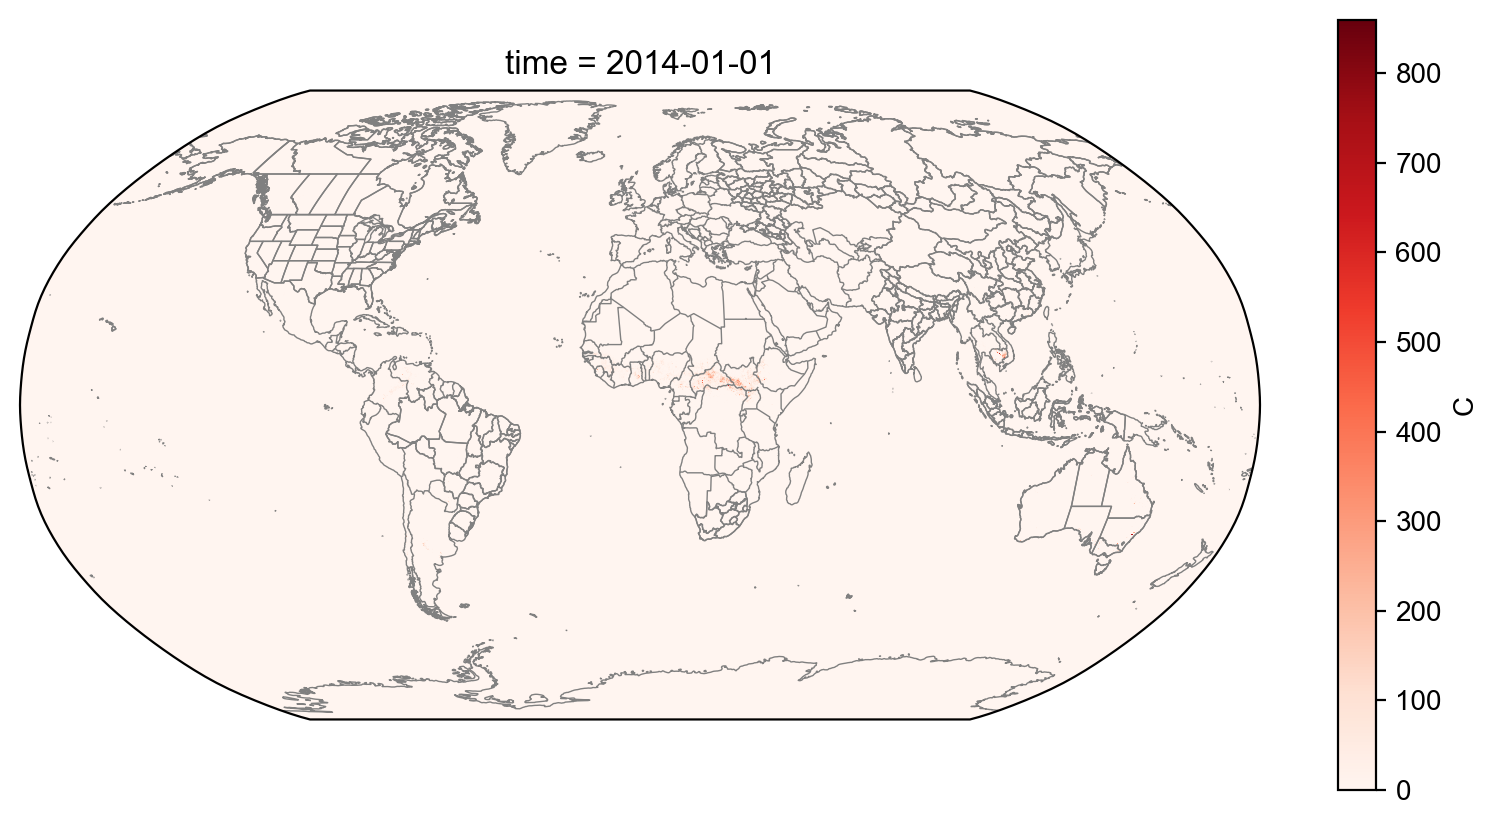

In [109]:
fig, ax = basemap()
ds.C.plot(cmap = 'Reds', transform = ccrs.PlateCarree());